In [0]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset

In [0]:
from google.colab import files
files.upload()

Saving resnet_model.py to resnet_model.py


{'resnet_model.py': b'import torch.nn as nn\nimport torch\nfrom typing import TypeVar, List, Tuple\n\nVector = TypeVar(\'Vector\', List[int], Tuple[int, int, int, int])\nTensor = TypeVar(\'Tensor\', torch.FloatTensor, torch.cuda.FloatTensor)\nshortcut_type = TypeVar(\'shortcut_type\', type(None), nn.modules.container.Sequential)\n\n\nclass BasicBlock(nn.Module):\n\n    """\n    Basic block for ResNet model (resnet18, resnet34).\n    Basic block contains 2 Convolution layers with ReLU, BatchNorms and optional projection shortcut.\n\n    :param in_filters (int): number  of input filters\n    :param out_filters (int): number of output filters\n    :param stride (int): stride for Convolution layers\n    :param padding (int): padding for Convolution layers\n    :param projection_shortcut (None or nn.Sequential): module for projection shortcut\n\n    """\n\n    def __init__(self, in_filters: int, out_filters: int, stride: int = 1,\n                 padding: int = 1, projection_shortcut: shor

In [0]:
from resnet_model import *

In [0]:
batch_size = 64

data_train = dset.MNIST('./', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                 transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(dset.MNIST('./', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.Resize((224,224)),
                               transforms.ToTensor(),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:06, 1611113.86it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 134290.91it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2204147.70it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 49556.48it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


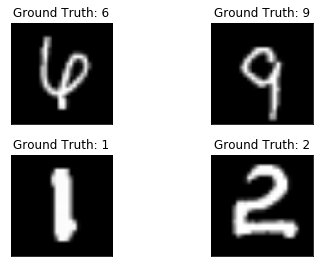

In [0]:
examples = enumerate(train_loader)
batch_idx, (xs, ys) = next(examples)
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(xs[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(ys[i]))
    plt.xticks([])
    plt.yticks([])

In [0]:
import tqdm
from tqdm import tqdm

def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        with tqdm(total=len(train_loader)) as progress_bar:
            for i_step, (x, y) in enumerate(train_loader):
                prediction = model(x)   
                loss_value = loss(prediction, y)
                optimizer.zero_grad()
                loss_value.backward()
                optimizer.step()
            
                _, indices = torch.max(prediction, 1)
                correct_samples_batch = torch.sum(indices == y)
                correct_samples += torch.sum(indices == y)
                total_samples_batch = y.shape[0]
                total_samples += y.shape[0]
            
                loss_accum += loss_value
                
                progress_bar.update()
                progress_bar.set_description(f'Train Loss at Batch {i_step}: {loss_value} , \
                                             Accuracy is {float(correct_samples_batch)/total_samples_batch}')

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        scheduler.step()
        
    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    val_accuracy = 0
    correct = 0
    total = 0
    for i_step, (x, y) in enumerate(loader):
        pred = model(x)
        
        _, indices = torch.max(pred, 1)
        correct += torch.sum(indices == y)
        total += y.shape[0]
        
        val_accuracy = float(correct)/total
        
    return val_accuracy

In [0]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    loader = torch.utils.data.DataLoader(dataset, 
                                           sampler=SubsetSampler(indices))
    predictions = []
    ground_truth = []
    for i_step, (x, y) in enumerate(loader):
        pred = model(x)
        _, indices = torch.max(pred, 1)
        predictions.append(int(indices))
        ground_truth.append(int(y))
    
    return np.array(predictions), np.array(ground_truth)

In [0]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.xlabel("predicted")
    plt.ylabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    for i in range(len(predictions)):
        confusion_matrix[ground_truth[i]][predictions[i]] += 1
    
    return confusion_matrix


In [0]:
resnet18 = ResNet([2,2,2,2], 3, 10, False)

resnet18.type(torch.FloatTensor)

parameters = resnet18.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.05, momentum=0.9, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 2)
loss_history, train_history, val_history = train_model(resnet18, train_loader, val_loader, loss, optimizer, scheduler, 5)

Train Loss at Batch 124: 0.22849062085151672 ,                                              Accuracy is 0.953125: 100%|██████████| 125/125 [38:34<00:00, 18.50s/it]
  0%|          | 0/125 [00:00<?, ?it/s]

Average loss: 0.486698, Train accuracy: 0.839500, Val accuracy: 0.865500


Train Loss at Batch 124: 0.0732215866446495 ,                                              Accuracy is 0.953125: 100%|██████████| 125/125 [38:32<00:00, 18.43s/it]
  0%|          | 0/125 [00:00<?, ?it/s]

Average loss: 0.167425, Train accuracy: 0.946500, Val accuracy: 0.969500


Train Loss at Batch 124: 0.016784951090812683 ,                                              Accuracy is 1.0: 100%|██████████| 125/125 [38:37<00:00, 18.58s/it]   
  0%|          | 0/125 [00:00<?, ?it/s]

Average loss: 0.142576, Train accuracy: 0.958125, Val accuracy: 0.876500


Train Loss at Batch 124: 0.028555452823638916 ,                                              Accuracy is 1.0: 100%|██████████| 125/125 [38:43<00:00, 18.75s/it]
  0%|          | 0/125 [00:00<?, ?it/s]

Average loss: 0.142296, Train accuracy: 0.958875, Val accuracy: 0.948500


Train Loss at Batch 124: 0.016531504690647125 ,                                              Accuracy is 1.0: 100%|██████████| 125/125 [38:41<00:00, 18.59s/it]    


Average loss: 0.114740, Train accuracy: 0.965250, Val accuracy: 0.901000


In [0]:
final_test_accuracy = compute_accuracy(resnet18, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9001


In [0]:
predictions, gt = evaluate_model(resnet18, data_train, val_indices)

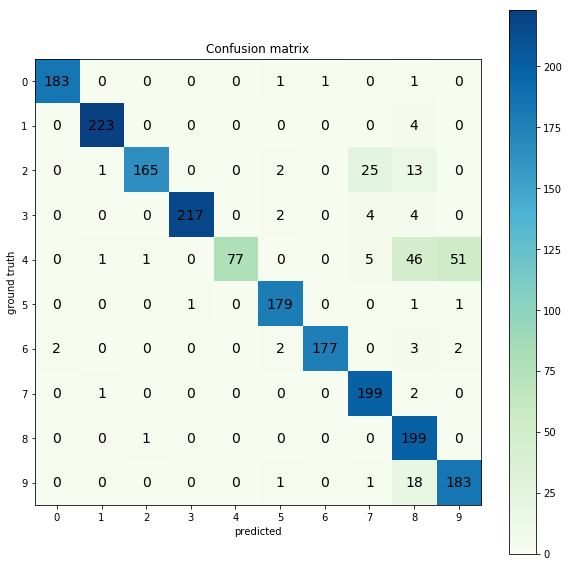

In [0]:
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)